In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
import optuna
from optuna.visualization import plot_slice
from sklearn.metrics import plot_confusion_matrix

import warnings

warnings.simplefilter('ignore')

D:\anaconda3\envs\myenv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

In [3]:
train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


### Visualization and Analysis

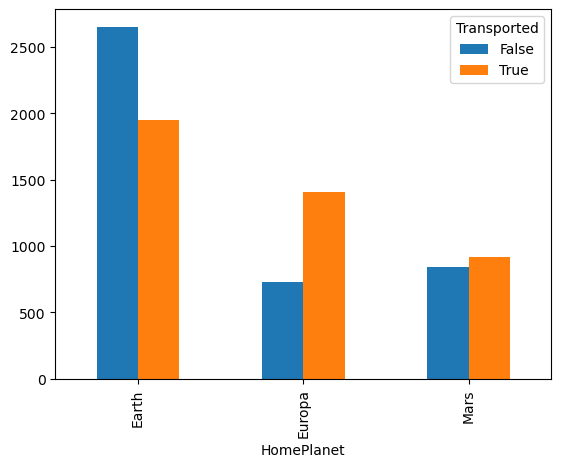

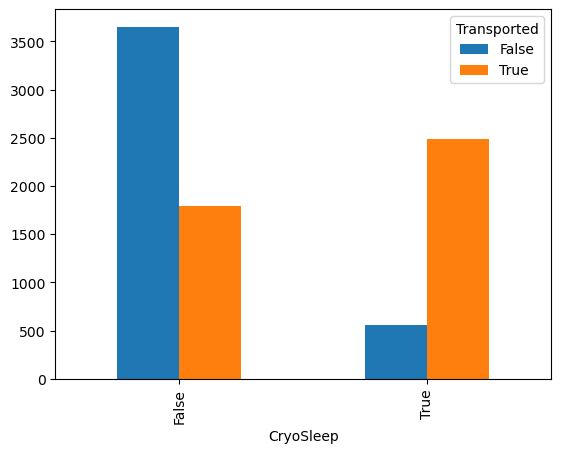

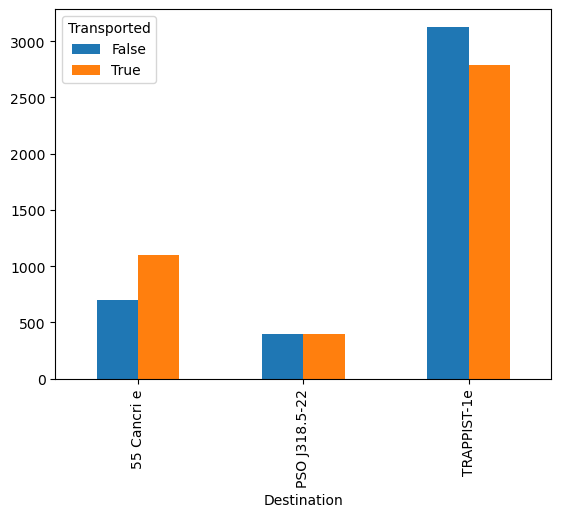

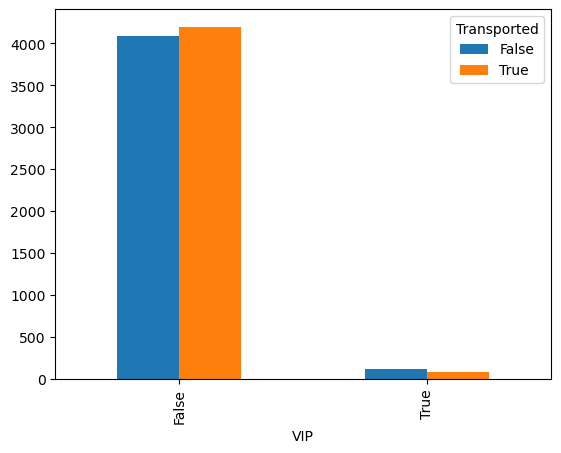

In [5]:
def plot_discrete_variable(feature, data=train):
    '''Plots discrete variable with a barplot by Transported rate'''
    crossTabResult = pd.crosstab(index=data[feature], columns=data['Transported'])
    crossTabResult.plot.bar()

for feature in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']:
    plot_discrete_variable(feature)

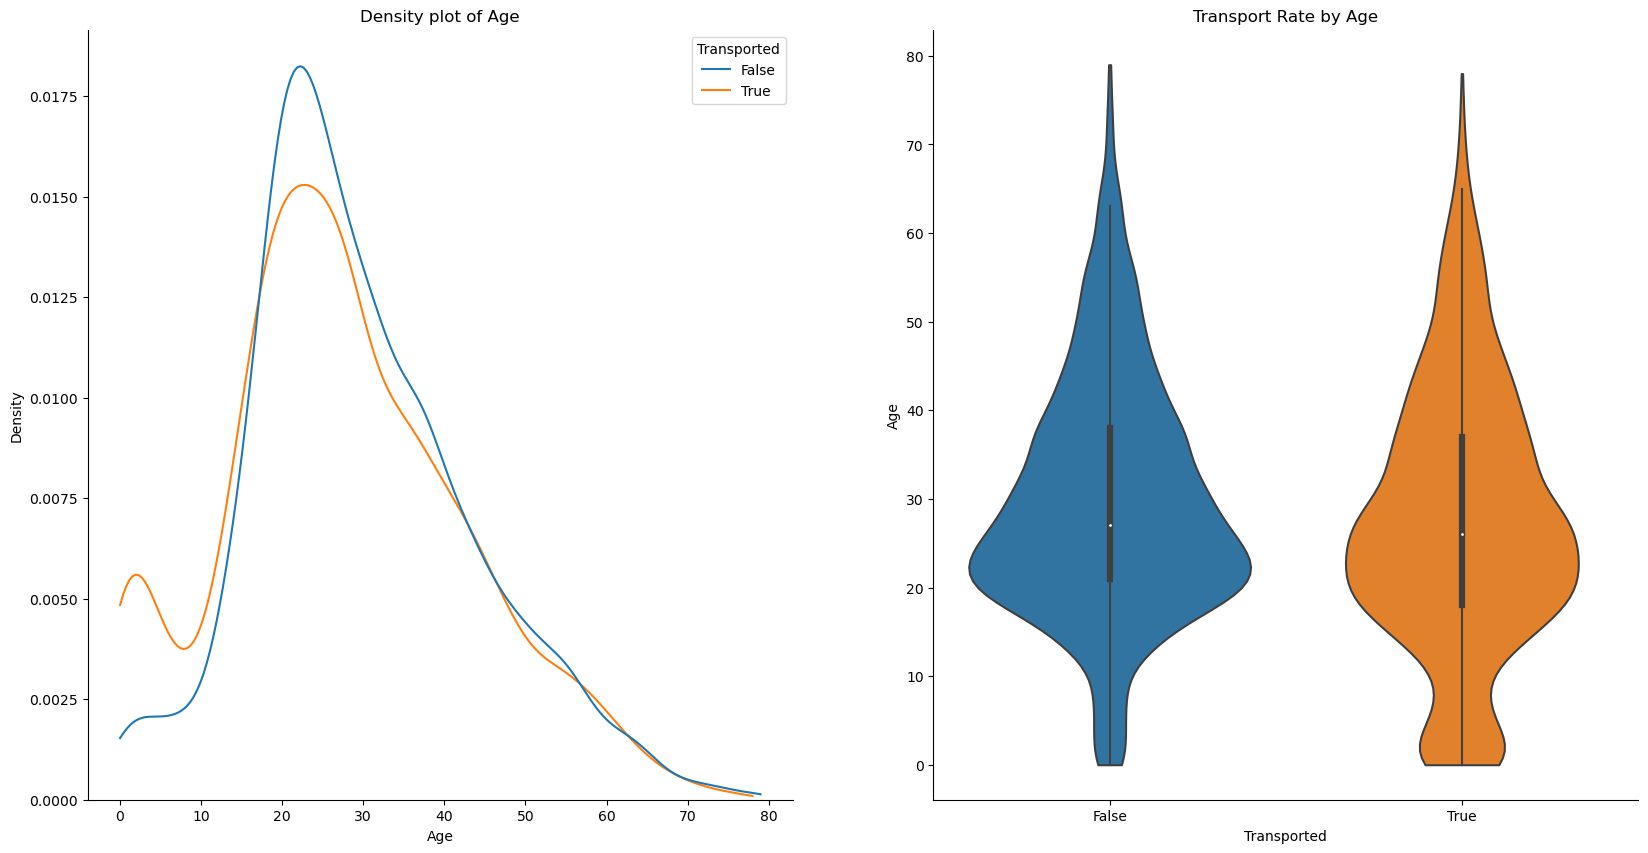

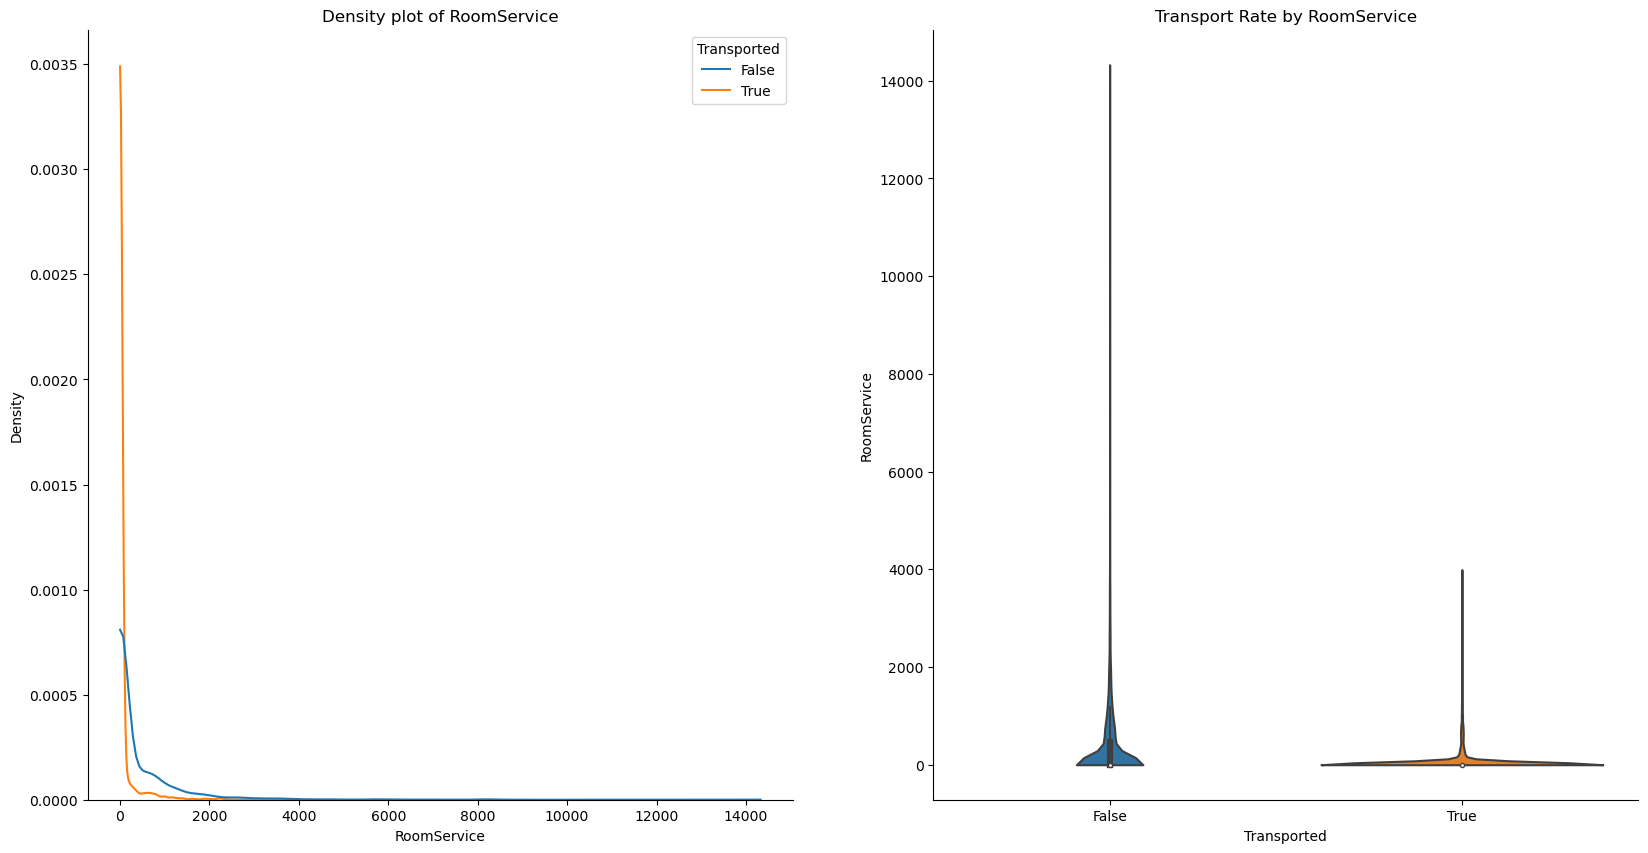

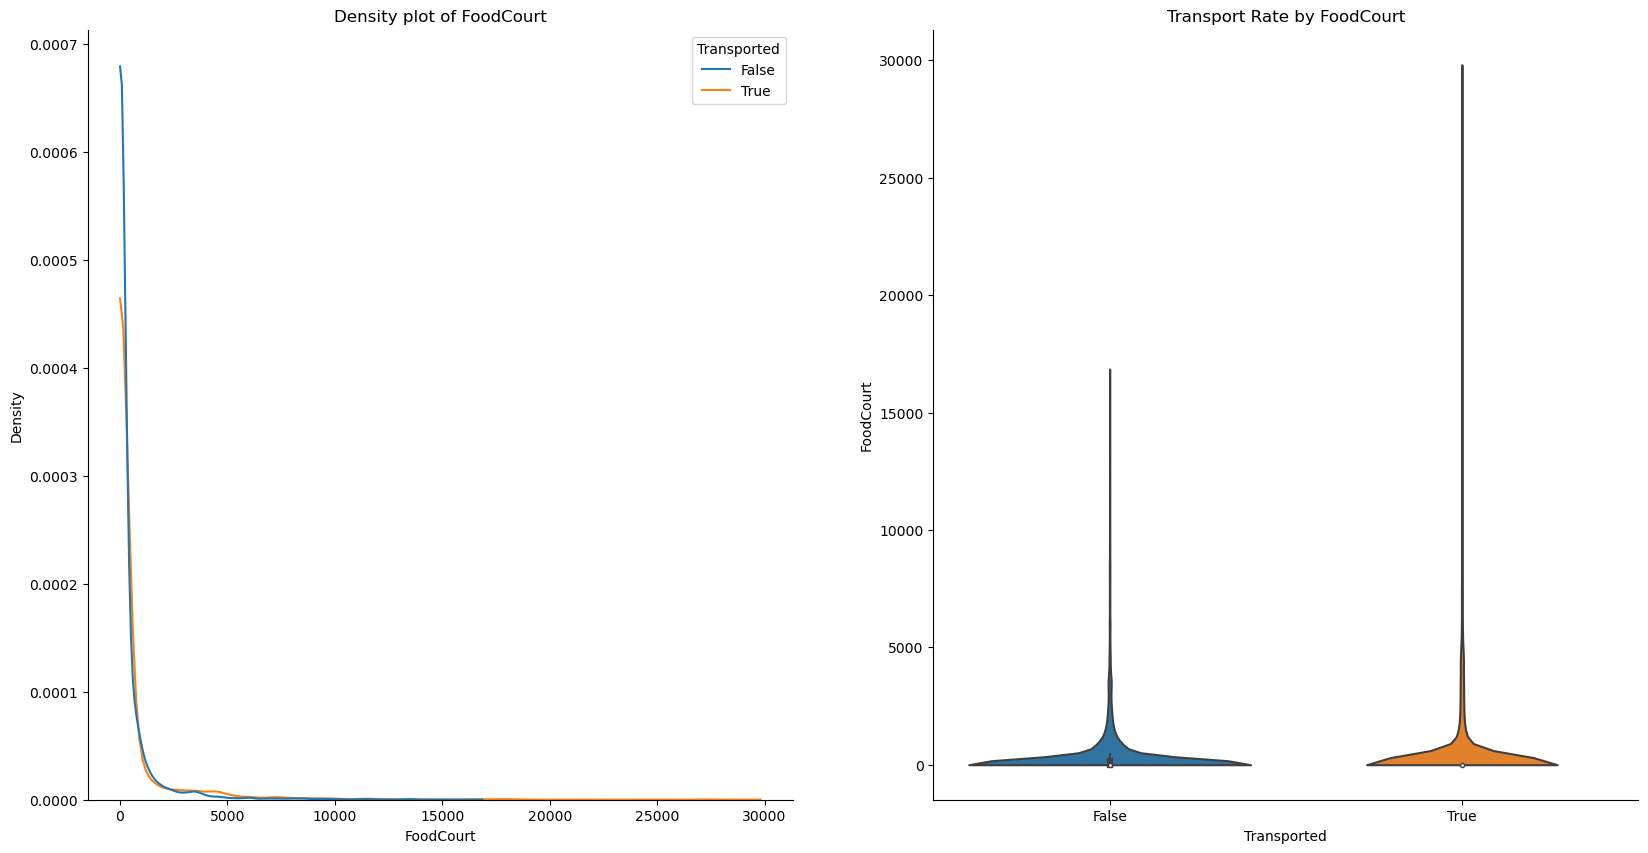

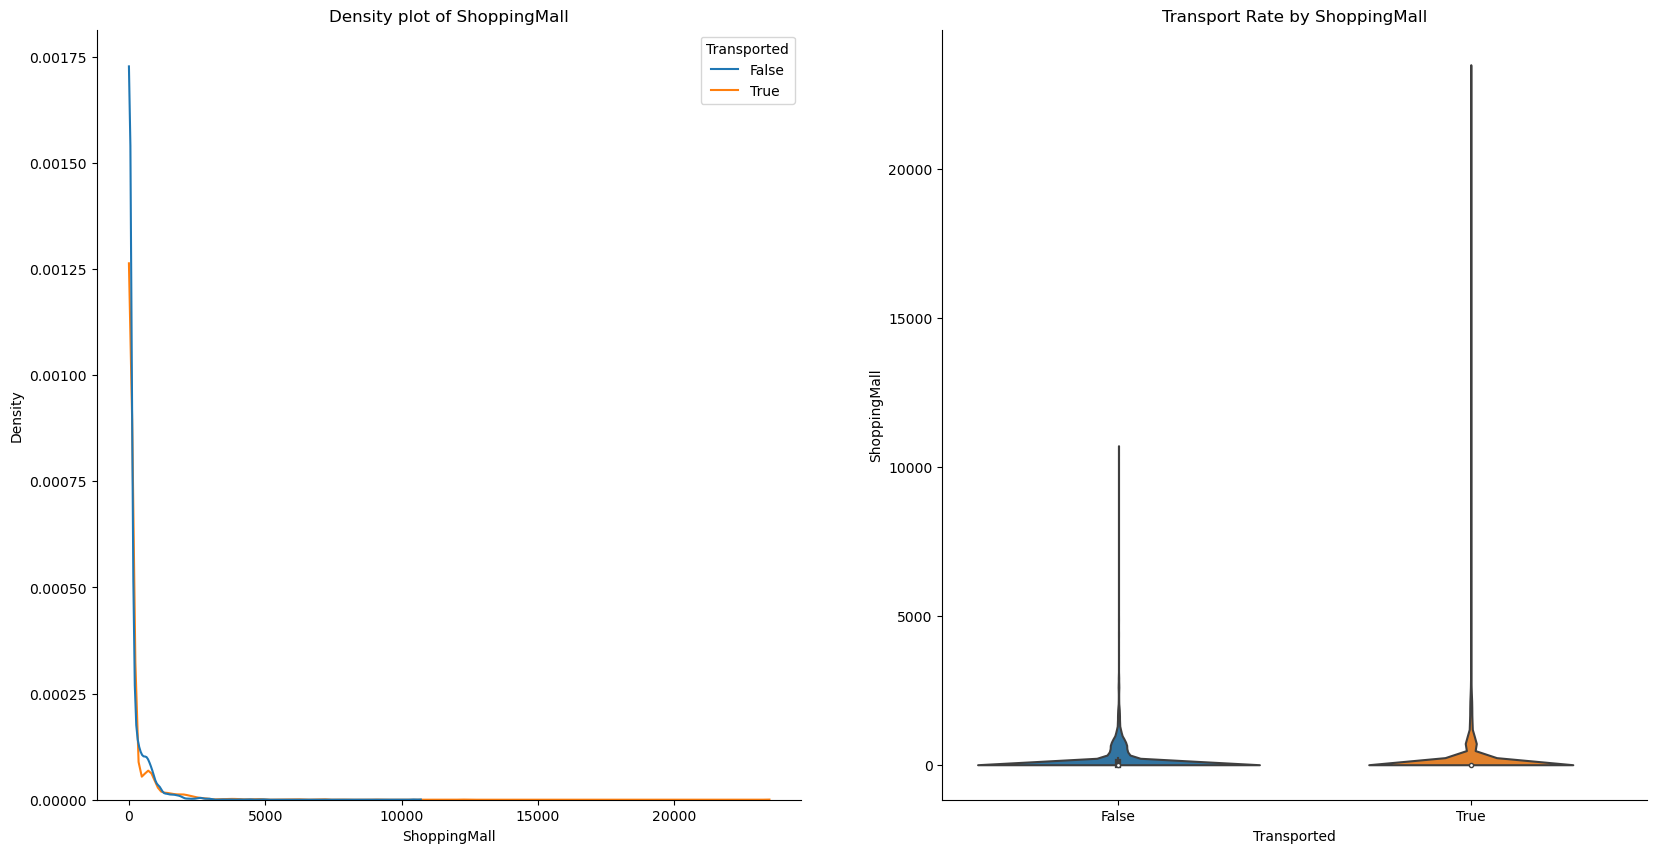

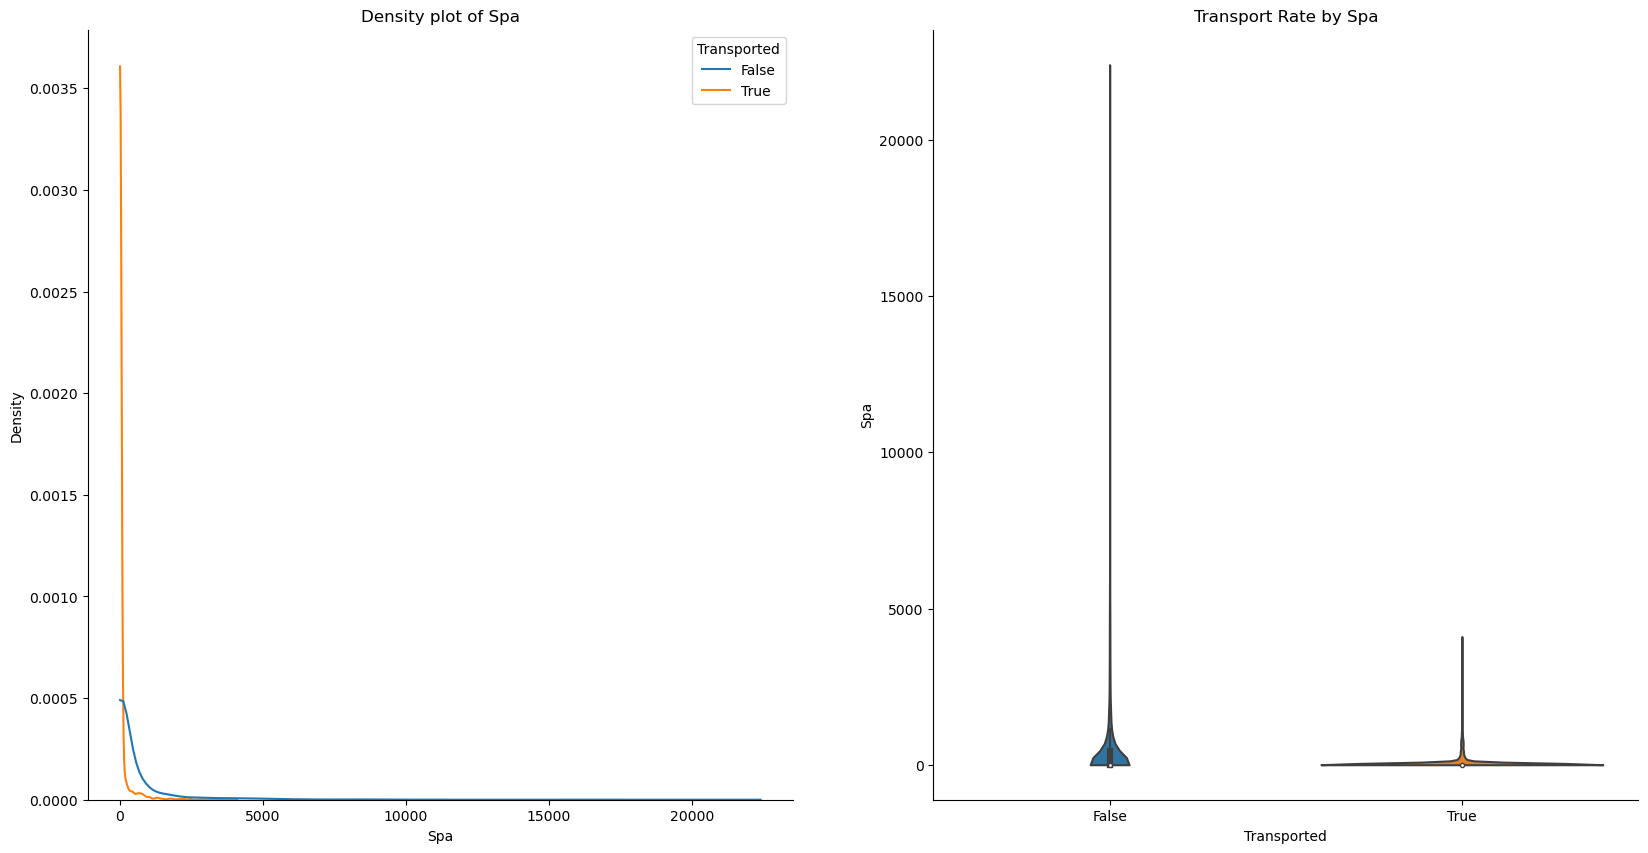

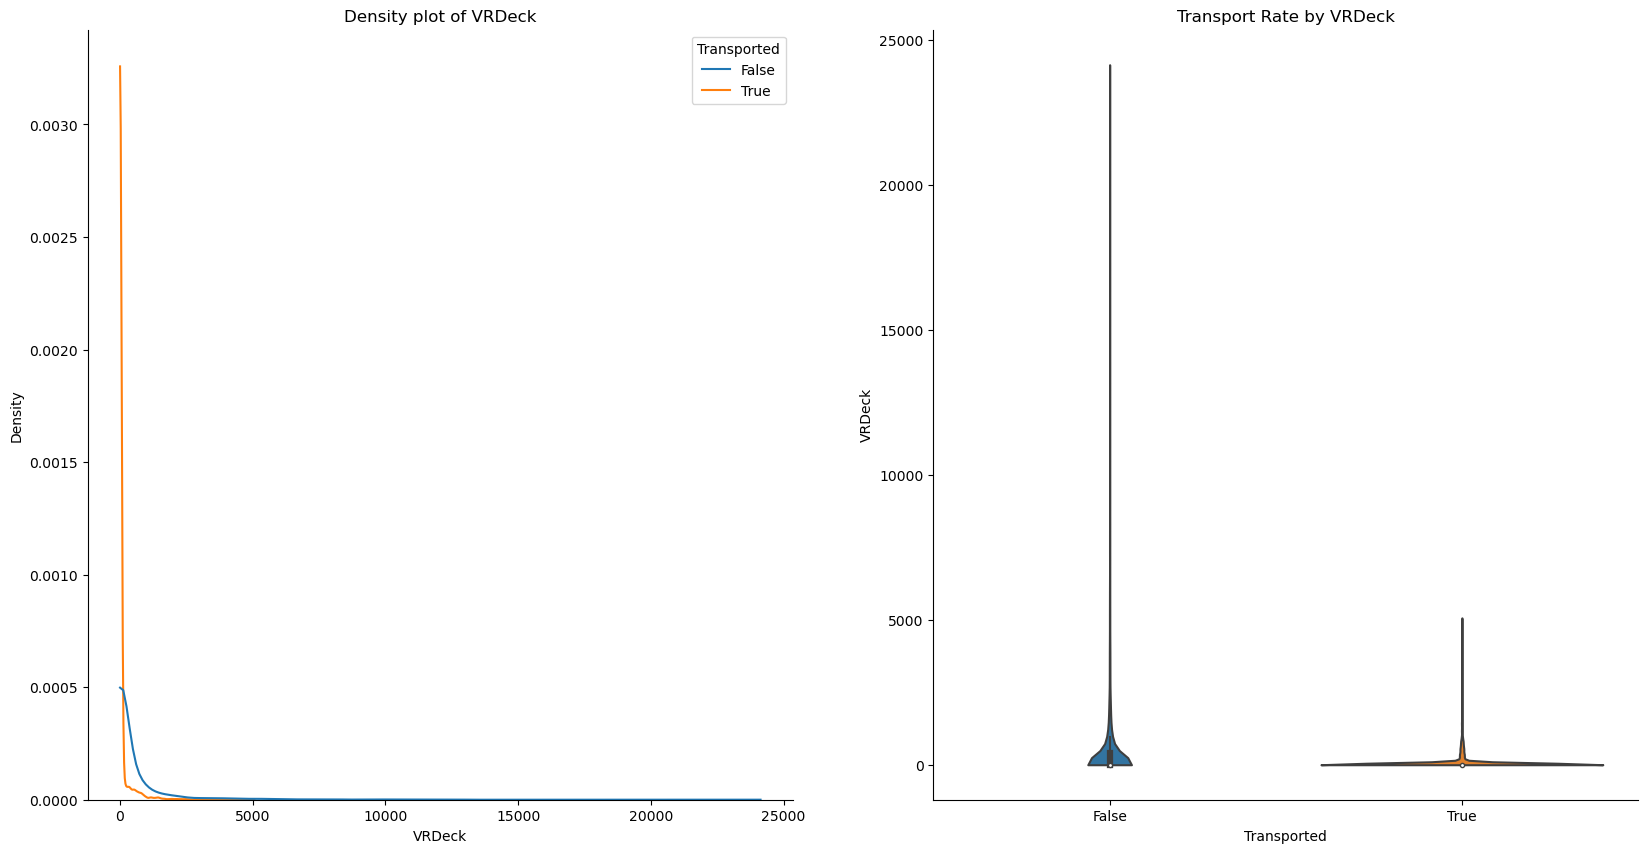

In [6]:
def plot_continuous_variable(feature, data=train):
    '''Plots continuous variable with a density plot and violinplot by survival rate'''
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    sns.kdeplot(x=f'{feature}', hue='Transported', data=data, ax=ax1, cut=0)
    sns.violinplot(x='Transported', y=f'{feature}', data=data, ax=ax2, cut=0)
    sns.despine()
    ax1.set_title(f"Density plot of {feature}")
    ax2.set_title(f"Transport Rate by {feature}")
    plt.show()
    
for feature in ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    plot_continuous_variable(feature)

it looks like Ages under 10 have different distribution.  
and also except Age, the other features need to transform to be more Gaussian-like.

### Preprocessing

check to see if we can take usefull information out of PassengerId:

In [7]:
group = train['PassengerId'].str.split('_', expand=True)
group['GroupSize'] = group.groupby(0)[1].transform('max')
group['GroupSize'] = group['GroupSize'].astype(int)
group

0   1  GroupSize
0     0001  01          1
1     0002  01          1
2     0003  01          2
3     0003  02          2
4     0004  01          1
...    ...  ..        ...
8688  9276  01          1
8689  9278  01          1
8690  9279  01          1
8691  9280  01          2
8692  9280  02          2

[8693 rows x 3 columns]

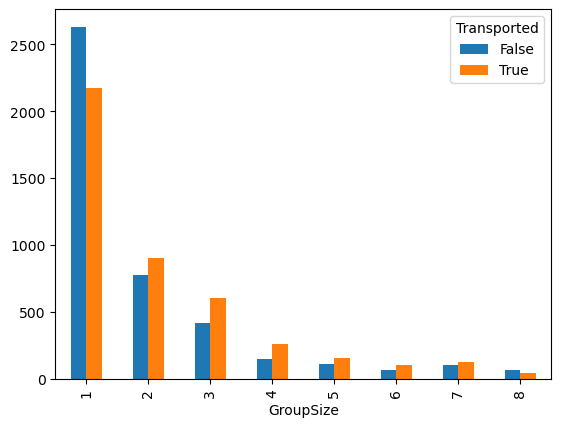

In [8]:
group['Transported'] = train['Transported']
plot_discrete_variable('GroupSize', data=group)

seems like when groupSize get bigger, the chance of transportation gets higher

In [9]:
group_test = test['PassengerId'].str.split('_', expand=True)
group_test['GroupSize'] = group.groupby(0)[1].transform('max')
group_test['GroupSize'] = group['GroupSize'].astype(int)

check to see if Cabin's different parts have relation with target or not:

In [10]:
cabin = train['Cabin'].str.split('/', expand=True)
cabin.columns = ['Deck', 'CabinNum', 'Side']
cabin['CabinNum'] = cabin['CabinNum'].astype(np.float64, errors='ignore')
cabin

Deck  CabinNum Side
0       B       0.0    P
1       F       0.0    S
2       A       0.0    S
3       A       0.0    S
4       F       1.0    S
...   ...       ...  ...
8688    A      98.0    P
8689    G    1499.0    S
8690    G    1500.0    S
8691    E     608.0    S
8692    E     608.0    S

[8693 rows x 3 columns]

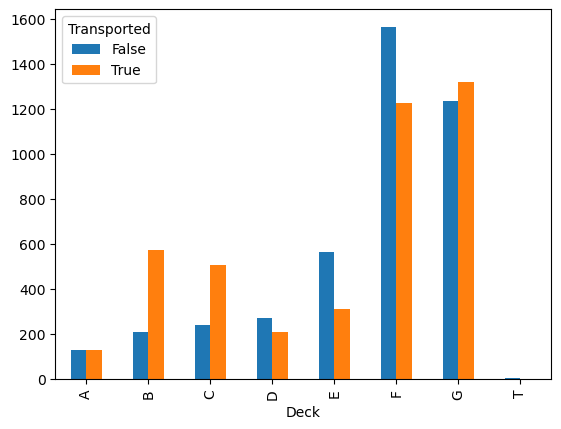

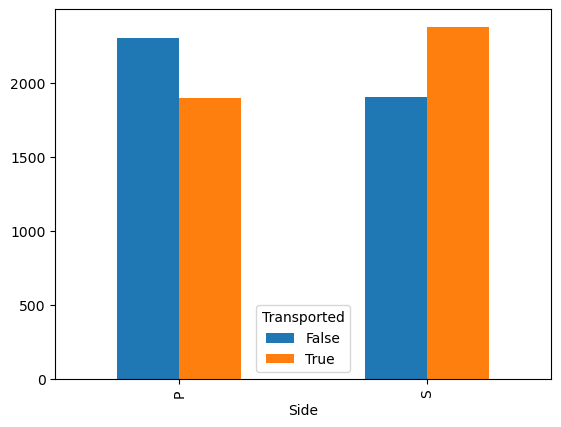

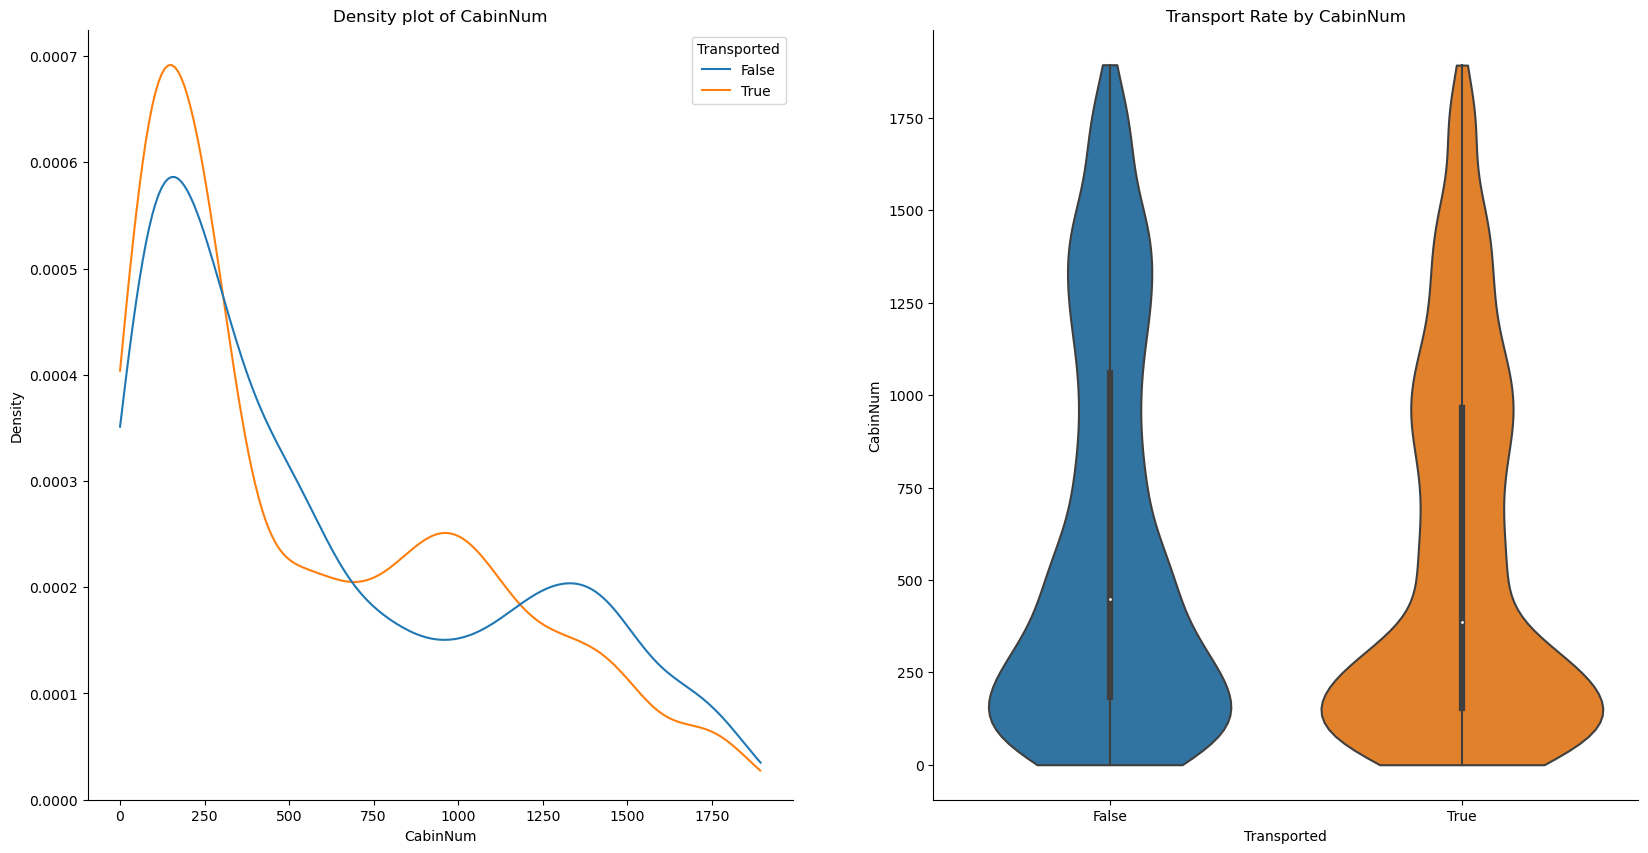

In [11]:
cabin['Transported'] = train['Transported']
plot_discrete_variable('Deck', data=cabin)
plot_discrete_variable('Side', data=cabin)
plot_continuous_variable('CabinNum', data=cabin)

In [12]:
cabin_test = test['Cabin'].str.split('/', expand=True)
cabin_test.columns = ['Deck', 'CabinNum', 'Side']
cabin_test['CabinNum'] = cabin['CabinNum'].astype(np.float64, errors='ignore')

### prepare data to feed to model

In [13]:
y = train['Transported']

In [14]:
X = train[train.columns.drop(['Name', 'PassengerId','Cabin', 'Transported'])].copy()
X['GroupSize'] = group['GroupSize']
X['Deck'] = cabin['Deck'].astype('category')
X['CabinNum'] = cabin['CabinNum']
X['Side'] = cabin['Side'].astype('category')
X['Age <= 10'] = train['Age'] <= 10
X['TotalSpend'] = train['RoomService'] + \
                            train['FoodCourt'] + \
                            train['ShoppingMall'] + train['VRDeck']
X['NoSpend'] = X['TotalSpend'] == 0
# X.set_index('PassengerId', inplace=True)

X_test = test[test.columns.drop(['Name', 'PassengerId','Cabin'])].copy()
X_test['GroupSize'] = group_test['GroupSize']
X_test['Deck'] = cabin_test['Deck'].astype('category')
X_test['CabinNum'] = cabin_test['CabinNum']
X_test['Side'] = cabin_test['Side'].astype('category')
X_test['Age <= 10'] = test['Age'] <= 10
X_test['TotalSpend'] = test['RoomService'] + \
                            test['FoodCourt'] + \
                            test['ShoppingMall'] + test['VRDeck']
X_test['NoSpend'] = X_test['TotalSpend'] == 0
# X_test.set_index('PassengerId', inplace=True)

plot a diagram to see how much features have influence over terget:

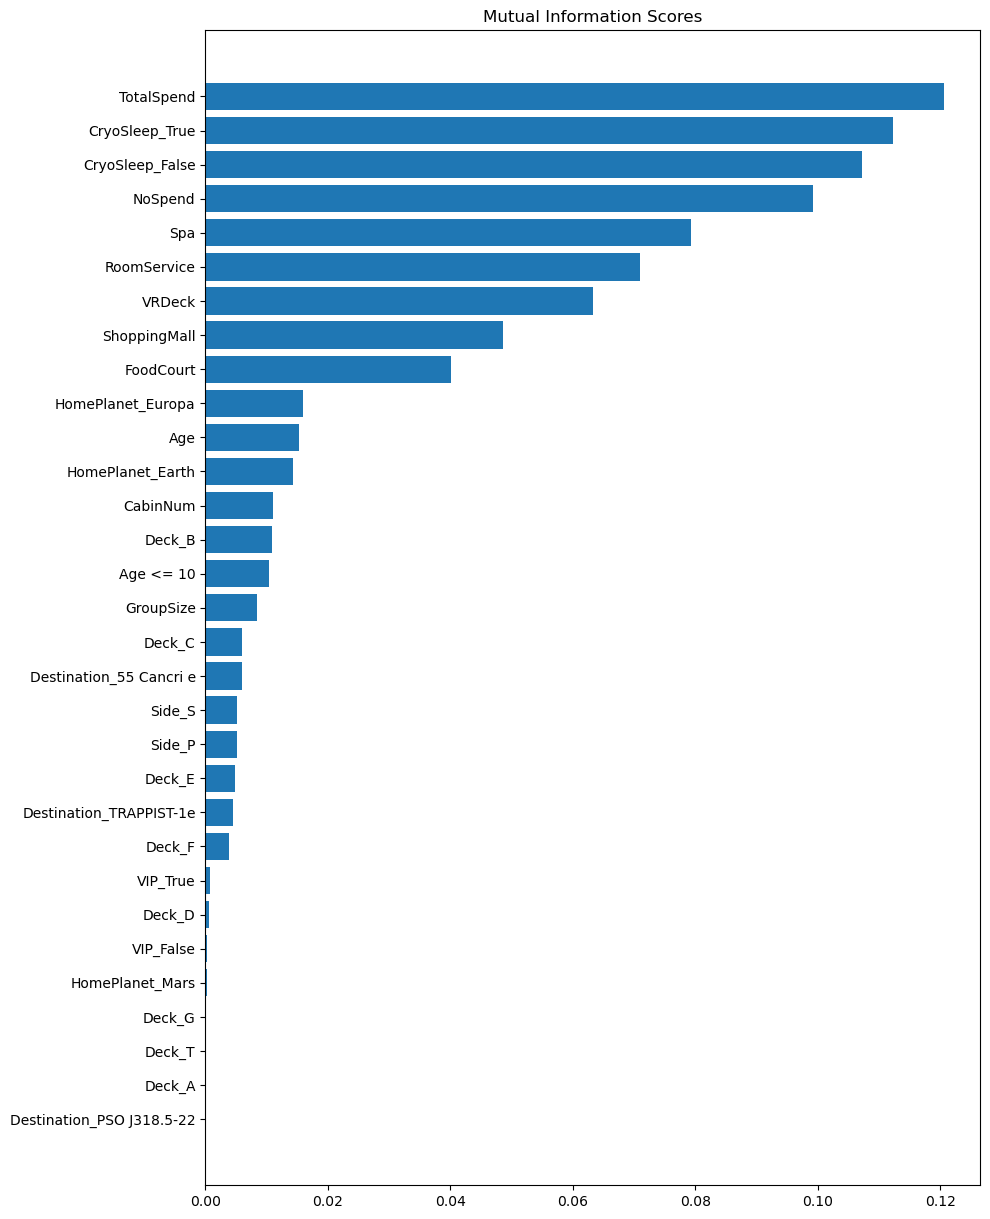

In [15]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(train, y):
    train = train.copy()
#     changes on train in this function, won't affect on the original train
    for colname in train.select_dtypes(["object", "category"]):
        train[colname], feature_names = train[colname].factorize()
        
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in train.dtypes]
    mi_scores = mutual_info_classif(train, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=train.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

X_dummies = pd.get_dummies(X)
mi_scores = make_mi_scores(X_dummies.fillna(-999), y)
f, ax = plt.subplots(figsize=(10, 15))
plot_mi_scores(mi_scores)

In [16]:
# make data more Gaussian-like
pt = PowerTransformer()

X[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend', 'CabinNum']] = \
pt.fit_transform(X[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend', 'CabinNum']])

X_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend', 'CabinNum']] = \
pt.transform(X_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend', 'CabinNum']])

In [17]:
categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)


numeric_pipeline = Pipeline(steps=[("imputer", KNNImputer()), ("Scaler", RobustScaler())])


cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

## Modeling and Verifying Model

In [ ]:
def score_dataset(X, y, xgb_params):
    
    classifier = XGBClassifier(**xgb_params)
    clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])
    score = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
    score = (score.mean())
    return score

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 5, 10),
        learning_rate=trial.suggest_float("learning_rate", 0, 0.5),
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        colsample_bynode=trial.suggest_float("colsample_bynode", 0.2, 1.0),
        colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    return score_dataset(X, y, xgb_params)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
best_params = study.best_params

In [19]:
plot_slice(study)

In [20]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', XGBClassifier(**best_params))]) 
my_pipeline.fit(X, y)

[11:40:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('Scaler',
                                                                   RobustScaler())]),
                                                  Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'GroupSize', 'CabinNum', 'TotalSpend'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  (...
                               learning_rate=0.12694919750720737,

In [21]:
my_pipeline.score(X, y)

0.8399861957897159

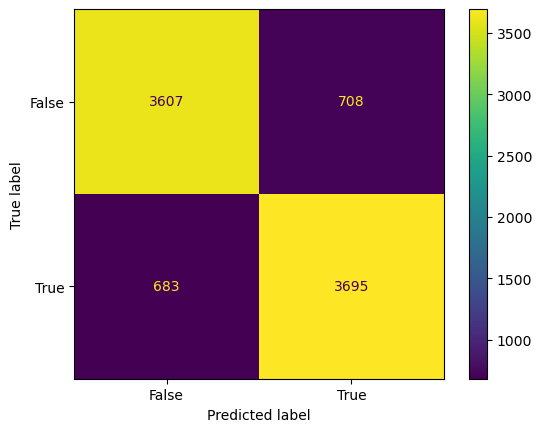

In [23]:
plot_confusion_matrix(my_pipeline, X, y)

## Submission

In [24]:
preds_test = my_pipeline.predict(X_test) 

# Save test predictions to file
output = pd.DataFrame({'PassengerId': test.PassengerId,'Transported': preds_test})
output.to_csv('submission.csv', index=False)